# Import Modules

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
tf.keras.utils.set_random_seed(42)


In [20]:
# Load the dataset into a DataFrame
df = pd.read_csv('datasets/cb513.csv')

# Filter to keep only rows with all 1.0s in cb513_mask
mask_filter = df['cb513_mask'].apply(lambda x: all(float(val) == 1.0 for val in x.split()))
filtered_df = df[mask_filter]

# Select only the required columns
filtered_df = filtered_df[['input', 'dssp3', 'cb513_mask']]

# Assuming you have the filtered_df DataFrame

# Open a file for writing
with open('datasets/cb513.txt', 'w') as f:
    # Iterate over the rows of the DataFrame
    for _, row in filtered_df.iterrows():
        sequence = row['input']
        structure = row['dssp3'].replace('H', 'h').replace('E', 'e').replace('C', '_')
        mask = row['cb513_mask']
        
        # Check if the mask contains all 1.0s
        if all(float(val) == 1.0 for val in mask.split()):
            f.write('<>\n')
            for aa, ss in zip(sequence, structure):
                f.write(f'{aa} {ss}\n')
            f.write('<end>\n')

# The filtered_dataset.txt file now contains the data in the desired format



# Import Dataset

In [21]:
# Define a function to convert amino acids and structures to one-hot

def one_hot_encode(seq, vocab):
    """One-hot encode a sequence based on a given vocabulary."""
    one_hot = np.zeros((len(seq), len(vocab)), dtype=np.float32)
    for i, char in enumerate(seq):
        if char in vocab:
            one_hot[i, vocab.index(char)] = 1.0
    return one_hot

def prepare_data(filepath, window_size=13):
    sequences = []
    structures = []
    current_seq = []
    current_struct = []
    processing_sequence = False  # Track when inside a sequence block

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '<>':  # Toggle processing flag
                if processing_sequence:  # We are ending a sequence block
                    if current_seq and current_struct:
                        seq_encoded = one_hot_encode(current_seq, aa_vocab)
                        struct_encoded = one_hot_encode(current_struct, structure_vocab)

                        # Apply sliding window
                        for i in range(len(seq_encoded) - window_size + 1):
                            window = seq_encoded[i:i + window_size]
                            label = struct_encoded[i + window_size // 2]
                            sequences.append(window)
                            structures.append(label)

                    current_seq = []
                    current_struct = []
                processing_sequence = not processing_sequence
                continue

            elif 'end' in line:  # Generalized handling for any 'end' marker
                continue  # Just skip this line, do not end processing sequence

            if processing_sequence:
                parts = line.split()
                if len(parts) != 2:
                    continue  # Skip malformed lines or lines that do not fit expected format
                current_seq.append(parts[0])
                current_struct.append(parts[1])

    return np.array(sequences), np.array(structures)


# Define your vocabularies
aa_vocab = 'ACDEFGHIKLMNPQRSTVWY_'  # 20 amino acids + 1 for gap/unknown
structure_vocab = 'he_'  # h for helix, e for sheet, _ for coil

# Example paths, replace with your actual file pathsin
train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'datasets/cb513.txt'

x_train, y_train = prepare_data(train_path)
x_test, y_test = prepare_data(test_path)


# Import Unseen Test Set

In [15]:
#def process_npy_data_for_test(path, window_size=13):
#    data = np.load(path)
#    data = data.reshape(-1, 700, 57)  # Reshape according to the original data structure
#
#    # Extract the 21 features for amino acids
#    X = data[:, :, :21]
#    X = X.transpose(0, 2, 1)  # Transpose to get shape (batch, features, sequence)
#    
#    # Assuming label information starts at index 22 and it's an 8-class system
#    y = data[:, :, 22:30]  # Extract labels
#    y = np.array([np.dot(yi, np.arange(8)) for yi in y])  # Convert to single integer labels if necessary
#    y = y.flatten()  # Flatten the array to correctly index it
#
#    # Convert 8 labels to 3 labels: mapping 0,3,4 -> 0 (coil); 1,2 -> 1 (helix); 5,6,7 -> 2 (sheet)
#    y = np.vectorize(lambda x: 0 if x in [0, 3, 4] else 1 if x in [1, 2] else 2)(y)
#    
#    # One-hot encoding of y into three categories
#    y_one_hot = np.zeros((y.shape[0], 3))
#    y_one_hot[np.arange(y.shape[0]), y] = 1
#    
#    # Apply sliding window to the sequences and labels
#    X_windows = []
#    y_windows = []
#    for sequence in range(X.shape[0]):
#        for start in range(X.shape[2] - window_size + 1):
#            X_window = X[sequence, :, start:start + window_size]
#            X_window = X_window.transpose()  # Transpose to get shape (window_size, features)
#            # Ensure that only one label is selected for the center of the window
#            y_window = y_one_hot[start + window_size // 2]
#            X_windows.append(X_window)
#            y_windows.append(y_window)
#
#    return np.array(X_windows), np.array(y_windows)
#
## Example usage
#test_path = 'datasets/CB513.npy'
#x_test, y_test = process_npy_data_for_test(test_path)


C:\Users\tomev\AppData\Local\Temp\ipykernel_23940\87086088.py:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  data = np.load(path)


In [22]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8110, 13, 21) (8110, 3)
(11098, 13, 21) (11098, 3)


In [23]:
tf.keras.utils.set_random_seed(42)


# Define the model architecture
model = Sequential([
    Flatten(input_shape=(13, 21)),  # Assuming input is a window of 13 amino acids, each encoded into 21 types
    Dense(40, activation='sigmoid'),  # First hidden layer with sigmoid activation, 40 units
    Dense(3, activation='linear')    # Output layer with sigmoid activation for 3 classes
])

# Compile the model
model.compile(optimizer='sgd',  # Stochastic gradient descent
              loss='mean_squared_error',  # Mean Squared Error as the loss function
              metrics=['accuracy'])  # Track accuracy


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,  # The number of epochs can be adjusted based on when you observe convergence
    batch_size=32,  # The batch size can be tuned based on your hardware capabilities
    validation_data=(x_test, y_test),  # Use your test set for validation
    callbacks=[early_stopping]

)

final_pred = model.predict(x_test)

Epoch 1/100


c:\Users\tomev\anaconda3\envs\bio-cwk\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4548 - loss: 0.2350 - val_accuracy: 0.4224 - val_loss: 0.2299
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5251 - loss: 0.2087 - val_accuracy: 0.4247 - val_loss: 0.2281
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5264 - loss: 0.2067 - val_accuracy: 0.4266 - val_loss: 0.2264
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5293 - loss: 0.2049 - val_accuracy: 0.4294 - val_loss: 0.2248
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5324 - loss: 0.2032 - val_accuracy: 0.4307 - val_loss: 0.2233
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5334 - loss: 0.2016 - val_accuracy: 0.4324 - val_loss: 0.2219
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5362 - loss: 0.2001 - val_accuracy: 0.4344 - val_loss: 0.2206
Epoch 8/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5370 - loss: 0.1986 - val_accuracy: 0.4374

# Evaluation

In [26]:

# Convert probabilities to class labels
y_true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(final_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, predicted_labels)
print("Q3 Score:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Calculate Matthews Correlation Coefficient for each class
# Calculate MCC for each class
mcc_scores = []
for i in range(3):  # 3 classes: Helix, Sheet, Coil
    # Create binary arrays for each class
    true_binary = (y_true_labels == i).astype(int)
    pred_binary = (predicted_labels == i).astype(int)

    # Calculate MCC and handle cases with constant predictions
    if np.unique(true_binary).size > 1 and np.unique(pred_binary).size > 1:
        mcc = matthews_corrcoef(true_binary, pred_binary)
    else:
        mcc = 0  # Not enough data to compute MCC or one class constant
    mcc_scores.append(mcc)
    print(f"MCC for class {['Helix', 'Sheet', 'Coil'][i]}: {mcc:.3f}")

Q3 Score: 0.5641557037304019
Confusion Matrix:
 [[1657  206 2136]
 [ 497  476 1421]
 [ 416  161 4128]]
MCC for class Helix: 0.325
MCC for class Sheet: 0.243
MCC for class Coil: 0.344


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


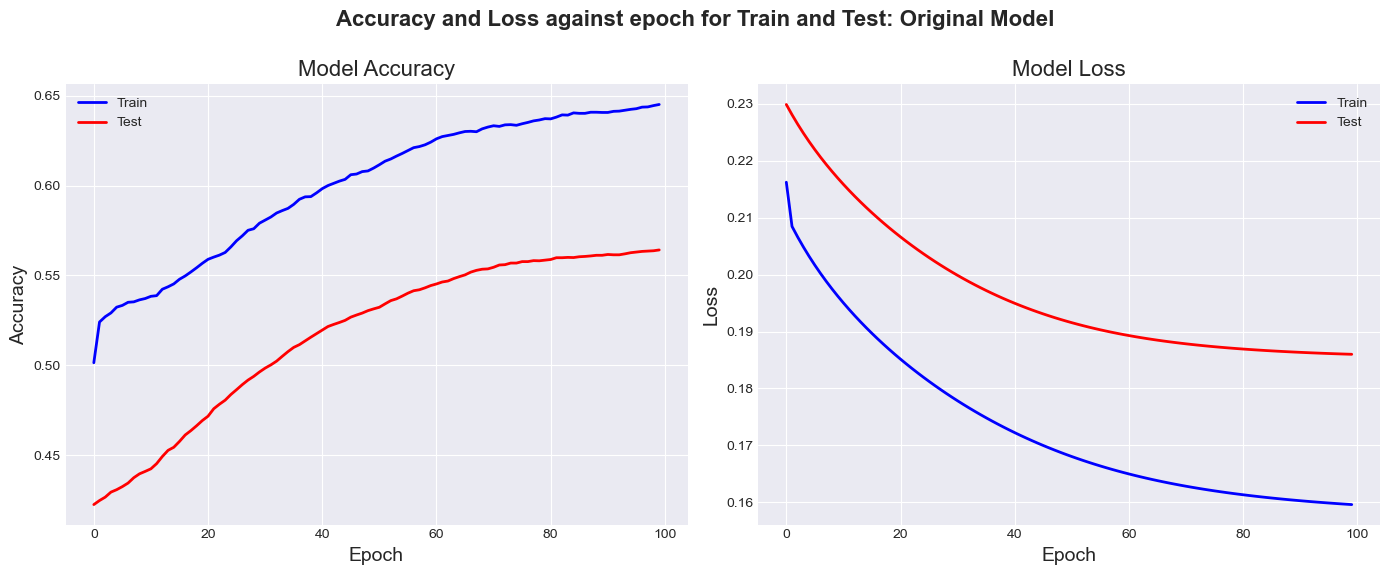

In [27]:
import matplotlib.pyplot as plt
print(plt.style.available)


def plot_history(history):
 # Set the style
    plt.style.use('seaborn-v0_8-dark')  # Using a clean and professional style

    # Create figure and set size
    plt.figure(figsize=(14, 6))
    plt.suptitle('Accuracy and Loss against epoch for Train and Test: Original Model', fontsize=16, fontweight='bold', y=0.95)

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], linestyle='-', color='red', linewidth=2)
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], linestyle='-', color='red', linewidth=2)
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the bottom rect to reduce the space
    
    # save the plot
    #plt.savefig('figures/original_model_accuracy_loss.png',dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

plot_history(history)  # Plot for the first model
#plot_history(history_second) 